# Comparison of sequential minimization strategies

Run the sequential minimization of the 10-parameter ansatz over the local and global cost functions with the fit method for the cost function sections.

In [1]:
import sys
import logging
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit, transpile

logging.basicConfig(level=logging.WARNING, format='%(asctime)s: %(message)s')
logging.getLogger('schwinger_rqd').setLevel(logging.INFO)

sys.path.append('..')
from cost_sections import FitSecond, FitFirst, FitGeneral, FitSymmetric
from pnp_ansatze import make_pnp_ansatz
from cost_functions import global_cost_function, local_cost_function
from sequential_minimizer import SequentialVCMinimizer, SectionGenSwitcher, IdealCost
from rttgen import CNOTBasedRtt
from cx_decomposition import cx_circuit
from model_circuits import single_step, two_steps

In [2]:
num_sites = 4
aJ = 1.
am = 0.5
omegadt = 0.2
# aJ = 0.7
# am = 0.439
# omegadt = 0.167
num_tstep = 6

backend = Aer.get_backend('statevector_simulator')
physical_qubits = None

In [3]:
def make_compiler_circuit():
    qubit_pairs = list(zip(range(0, num_sites - 1), range(1, num_sites)))

    rtts = dict((qubits, CNOTBasedRtt(backend, qubits)) for qubits in qubit_pairs)
    cxs = dict((qubits, cx_circuit(backend, *qubits)) for qubits in qubit_pairs)
    cxs.update((qubits[::-1], cx_circuit(backend, *qubits[::-1])) for qubits in qubit_pairs)

    two_step_circuit = two_steps(num_sites, aJ, am, omegadt, rtts=rtts, cxs=cxs)

    target_circuit = QuantumCircuit(num_sites)
    target_circuit.x([0, 2])
    target_circuit.compose(two_step_circuit, inplace=True)

    uncomputer = make_pnp_ansatz(num_qubits=num_sites, num_layers=num_sites // 2, initial_x_positions=[1, 2], structure=[(1, 2), (0, 1), (2, 3)], first_layer_structure=[(0, 1), (2, 3)]).inverse()

    return target_circuit.compose(uncomputer)

In [4]:
def make_minimizer(compiler_circuit, cost_function):
    section_generators = [FitGeneral] * len(compiler_circuit.parameters)
    if compiler_circuit.num_qubits == 2:
        section_generators[0] = FitSecond
        section_generators[1] = FitFirst
    elif compiler_circuit.num_qubits == 4:
        section_generators[0] = FitSecond
        section_generators[1] = FitFirst
        section_generators[2] = FitSecond
        section_generators[3] = FitFirst
        section_generators[5] = FitFirst

    minimizer = SequentialVCMinimizer(compiler_circuit, cost_function, section_generators, backend, shots_per_job=4096, num_jobs=1)

    return minimizer

In [5]:
def callback_sweep(minimizer):
    state = minimizer.state
    if 'initial_param_val' in state:
        distance = np.max(np.abs(state['param_val'] - state['initial_param_val']))
        cost_update = state['cost'] - state['initial_cost']
    else:
        distance = 'n/a'
        cost_update = 'n/a'
        
    print('isweep', state['isweep'], 'update distance', distance, 'cost', state['cost'], 'cost update', cost_update, 'total shots', state['shots'])
    print('params [' + ', '.join(map(str, state['param_val'])) + ']')
    
def switch_to_gradient_descent(minimizer):
    print('Switching to gradient descent at cost', minimizer.state['cost'])
    minimizer.switch_strategy('gradient-descent')
        
def switch_to_gradient_descent_by_absolute_cost(minimizer):
    if minimizer.state['strategy'] != 'gradient-descent' and minimizer.state['cost'] < 0.02:
        switch_to_gradient_descent(minimizer)

def switch_to_gradient_descent_by_cost_update(minimizer):
    cost_update = minimizer.state['cost'] - minimizer.state['initial_cost']
    if minimizer.state['strategy'] != 'gradient-descent' and cost_update < 0. and cost_update > -0.1:
        switch_to_gradient_descent(minimizer)

In [6]:
import multiprocessing

def run_minimizer(cost_type, strategy, queue):
    if cost_type == 'local':
        cost_function = local_cost_function
    else:
        cost_function = global_cost_function
        
    compiler_circuit = make_compiler_circuit()
    
    minimizer = make_minimizer(compiler_circuit, cost_function)
    
    ideal_cost = IdealCost(compiler_circuit)
    minimizer.callbacks_sweep.append(ideal_cost.callback_sweep)
        
    if '_gradient-descent' in strategy:
        minimizer.callbacks_sweep.append(switch_to_gradient_descent_by_cost_update)
    
    #switch_to_symmetric = SectionGenSwitcher(FitSymmetric, [4, 6, 7, 8, 9], 0.015)
    #minimizer.callbacks_sweep.append(switch_to_symmetric.callback_sweep)
    
    initial_param_val = np.ones(len(compiler_circuit.parameters), dtype='f8') * np.pi / 4.
    initial_strategy = strategy.replace('_gradient-descent', '')
    param_val = minimizer.minimize(initial_param_val, strategy=initial_strategy)
    
    if queue:
        queue.put((cost_type, strategy, param_val, ideal_cost.shots, ideal_cost.costs))
    else:
        return param_val, ideal_cost.shots, ideal_cost.costs
    
def driver():
    procs = dict()
    queue = multiprocessing.Queue()
    for cost_type in ['local', 'global']:
        for strategy in ['sequential', 'sequential_gradient-descent', 'largest-drop', 'largest-drop_gradient-descent']:
            proc = multiprocessing.Process(target=run_minimizer, args=(cost_type, strategy, queue))
            proc.start()
            procs[(cost_type, strategy)] = proc
            
    results = dict()
        
    while len(procs) != 0:
        cost_type, strategy, param_val, shots_values, cost_values = queue.get()
        print('{} {} returned'.format(cost_type, strategy))
        procs.pop((cost_type, strategy)).join()
        results[(cost_type, strategy)] = (param_val, shots_values, cost_values)
        
    return results    

In [7]:
#results = driver()
results = dict()
for cost_type in ['local', 'global']:
    for strategy in ['sequential', 'sequential_gradient-descent', 'largest-drop', 'largest-drop_gradient-descent']:
        print(cost_type, strategy)
        results[(cost_type, strategy)] = run_minimizer(cost_type, strategy, None)

local sequential


2021-12-02 14:23:21,546: Starting minimize() with initial parameter values [0.78539816 0.78539816 0.78539816 0.78539816 0.78539816 0.78539816
 0.78539816 0.78539816 0.78539816 0.78539816]
2021-12-02 14:23:21,547: Sweep 0 with strategy sequential - current cost 1.0 current shots 0
2021-12-02 14:23:21,548: calculate cost section over parameter 0
2021-12-02 14:23:22,302: calculate cost section over parameter 1
2021-12-02 14:23:22,602: calculate cost section over parameter 2
2021-12-02 14:23:22,778: calculate cost section over parameter 3
2021-12-02 14:23:22,955: calculate cost section over parameter 4
2021-12-02 14:23:23,438: calculate cost section over parameter 5
2021-12-02 14:23:23,602: calculate cost section over parameter 6
2021-12-02 14:23:23,853: calculate cost section over parameter 7
2021-12-02 14:23:24,242: calculate cost section over parameter 8
2021-12-02 14:23:24,557: calculate cost section over parameter 9
2021-12-02 14:23:24,863: Sweep 1 with strategy sequential - current c

local sequential_gradient-descent


2021-12-02 14:25:29,871: Starting minimize() with initial parameter values [0.78539816 0.78539816 0.78539816 0.78539816 0.78539816 0.78539816
 0.78539816 0.78539816 0.78539816 0.78539816]
2021-12-02 14:25:29,872: Sweep 0 with strategy sequential - current cost 1.0 current shots 0
2021-12-02 14:25:29,873: calculate cost section over parameter 0
2021-12-02 14:25:30,055: calculate cost section over parameter 1
2021-12-02 14:25:30,242: calculate cost section over parameter 2
2021-12-02 14:25:30,446: calculate cost section over parameter 3
2021-12-02 14:25:30,787: calculate cost section over parameter 4
2021-12-02 14:25:31,138: calculate cost section over parameter 5
2021-12-02 14:25:31,316: calculate cost section over parameter 6
2021-12-02 14:25:31,729: calculate cost section over parameter 7
2021-12-02 14:25:31,991: calculate cost section over parameter 8
2021-12-02 14:25:32,444: calculate cost section over parameter 9
2021-12-02 14:25:32,823: Sweep 1 with strategy sequential - current c

Switching to gradient descent at cost 0.0036746526037348404


2021-12-02 14:25:36,276: calculate cost section over parameter 1
2021-12-02 14:25:36,775: calculate cost section over parameter 2
2021-12-02 14:25:37,003: calculate cost section over parameter 3
2021-12-02 14:25:37,335: calculate cost section over parameter 4
2021-12-02 14:25:37,831: calculate cost section over parameter 5
2021-12-02 14:25:38,092: calculate cost section over parameter 6
2021-12-02 14:25:38,388: calculate cost section over parameter 7
2021-12-02 14:25:38,847: calculate cost section over parameter 8
2021-12-02 14:25:39,174: calculate cost section over parameter 9
2021-12-02 14:25:39,517: Sweep 3 with strategy gradient-descent - current cost 0.004809086045087726 current shots 1966080
2021-12-02 14:25:39,517: gradient descent: Calculating cost sections for all parameters
2021-12-02 14:25:39,518: calculate cost section over parameter 0
2021-12-02 14:25:39,864: calculate cost section over parameter 1
2021-12-02 14:25:40,135: calculate cost section over parameter 2
2021-12-02

local largest-drop


2021-12-02 14:26:15,406: Starting minimize() with initial parameter values [0.78539816 0.78539816 0.78539816 0.78539816 0.78539816 0.78539816
 0.78539816 0.78539816 0.78539816 0.78539816]
2021-12-02 14:26:15,407: Sweep 0 with strategy largest-drop - current cost 1.0 current shots 0
2021-12-02 14:26:15,408: largest drop: Calculating cost sections for all parameters
2021-12-02 14:26:15,408: calculate cost section over parameter 0
2021-12-02 14:26:15,587: calculate cost section over parameter 1
2021-12-02 14:26:15,900: calculate cost section over parameter 2
2021-12-02 14:26:16,077: calculate cost section over parameter 3
2021-12-02 14:26:16,247: calculate cost section over parameter 4
2021-12-02 14:26:16,487: calculate cost section over parameter 5
2021-12-02 14:26:16,833: calculate cost section over parameter 6
2021-12-02 14:26:17,163: calculate cost section over parameter 7
2021-12-02 14:26:17,529: calculate cost section over parameter 8
2021-12-02 14:26:17,864: calculate cost section 

local largest-drop_gradient-descent


2021-12-02 14:27:14,038: Starting minimize() with initial parameter values [0.78539816 0.78539816 0.78539816 0.78539816 0.78539816 0.78539816
 0.78539816 0.78539816 0.78539816 0.78539816]
2021-12-02 14:27:14,039: Sweep 0 with strategy largest-drop - current cost 1.0 current shots 0
2021-12-02 14:27:14,039: largest drop: Calculating cost sections for all parameters
2021-12-02 14:27:14,040: calculate cost section over parameter 0
2021-12-02 14:27:14,200: calculate cost section over parameter 1
2021-12-02 14:27:14,370: calculate cost section over parameter 2
2021-12-02 14:27:14,548: calculate cost section over parameter 3
2021-12-02 14:27:15,071: calculate cost section over parameter 4
2021-12-02 14:27:15,306: calculate cost section over parameter 5
2021-12-02 14:27:15,469: calculate cost section over parameter 6
2021-12-02 14:27:15,904: calculate cost section over parameter 7
2021-12-02 14:27:16,135: calculate cost section over parameter 8
2021-12-02 14:27:16,470: calculate cost section 

Switching to gradient descent at cost 0.20503295545527103


2021-12-02 14:27:20,458: calculate cost section over parameter 1
2021-12-02 14:27:20,646: calculate cost section over parameter 2
2021-12-02 14:27:20,833: calculate cost section over parameter 3
2021-12-02 14:27:21,028: calculate cost section over parameter 4
2021-12-02 14:27:21,476: calculate cost section over parameter 5
2021-12-02 14:27:21,673: calculate cost section over parameter 6
2021-12-02 14:27:21,938: calculate cost section over parameter 7
2021-12-02 14:27:22,439: calculate cost section over parameter 8
2021-12-02 14:27:22,719: calculate cost section over parameter 9
2021-12-02 14:27:23,114: Sweep 3 with strategy gradient-descent - current cost 0.303539221073838 current shots 753664
2021-12-02 14:27:23,115: gradient descent: Calculating cost sections for all parameters
2021-12-02 14:27:23,115: calculate cost section over parameter 0
2021-12-02 14:27:23,311: calculate cost section over parameter 1
2021-12-02 14:27:23,505: calculate cost section over parameter 2
2021-12-02 14:

global sequential


2021-12-02 14:28:14,617: Starting minimize() with initial parameter values [0.78539816 0.78539816 0.78539816 0.78539816 0.78539816 0.78539816
 0.78539816 0.78539816 0.78539816 0.78539816]
2021-12-02 14:28:14,618: Sweep 0 with strategy sequential - current cost 1.0 current shots 0
2021-12-02 14:28:14,619: calculate cost section over parameter 0
2021-12-02 14:28:14,804: calculate cost section over parameter 1
2021-12-02 14:28:14,992: calculate cost section over parameter 2
2021-12-02 14:28:15,186: calculate cost section over parameter 3
2021-12-02 14:28:15,496: calculate cost section over parameter 4
2021-12-02 14:28:15,872: calculate cost section over parameter 5
2021-12-02 14:28:16,061: calculate cost section over parameter 6
2021-12-02 14:28:16,541: calculate cost section over parameter 7
2021-12-02 14:28:16,830: calculate cost section over parameter 8
2021-12-02 14:28:17,078: calculate cost section over parameter 9
2021-12-02 14:28:17,453: Sweep 1 with strategy sequential - current c

global sequential_gradient-descent


2021-12-02 14:29:19,710: Starting minimize() with initial parameter values [0.78539816 0.78539816 0.78539816 0.78539816 0.78539816 0.78539816
 0.78539816 0.78539816 0.78539816 0.78539816]
2021-12-02 14:29:19,711: Sweep 0 with strategy sequential - current cost 1.0 current shots 0
2021-12-02 14:29:19,712: calculate cost section over parameter 0
2021-12-02 14:29:19,882: calculate cost section over parameter 1
2021-12-02 14:29:20,063: calculate cost section over parameter 2
2021-12-02 14:29:20,251: calculate cost section over parameter 3
2021-12-02 14:29:20,564: calculate cost section over parameter 4
2021-12-02 14:29:20,942: calculate cost section over parameter 5
2021-12-02 14:29:21,130: calculate cost section over parameter 6
2021-12-02 14:29:21,596: calculate cost section over parameter 7
2021-12-02 14:29:21,832: calculate cost section over parameter 8
2021-12-02 14:29:22,051: calculate cost section over parameter 9
2021-12-02 14:29:22,409: Sweep 1 with strategy sequential - current c

Switching to gradient descent at cost -0.005632246480157144


2021-12-02 14:29:28,529: calculate cost section over parameter 1
2021-12-02 14:29:28,800: calculate cost section over parameter 2
2021-12-02 14:29:29,072: calculate cost section over parameter 3
2021-12-02 14:29:29,281: calculate cost section over parameter 4
2021-12-02 14:29:29,719: calculate cost section over parameter 5
2021-12-02 14:29:29,909: calculate cost section over parameter 6
2021-12-02 14:29:30,256: calculate cost section over parameter 7
2021-12-02 14:29:30,735: calculate cost section over parameter 8
2021-12-02 14:29:30,972: calculate cost section over parameter 9
2021-12-02 14:29:31,381: Sweep 4 with strategy gradient-descent - current cost -0.005359932990588568 current shots 2621440
2021-12-02 14:29:31,382: gradient descent: Calculating cost sections for all parameters
2021-12-02 14:29:31,383: calculate cost section over parameter 0
2021-12-02 14:29:31,576: calculate cost section over parameter 1
2021-12-02 14:29:31,850: calculate cost section over parameter 2
2021-12-0

global largest-drop


2021-12-02 14:29:40,711: Starting minimize() with initial parameter values [0.78539816 0.78539816 0.78539816 0.78539816 0.78539816 0.78539816
 0.78539816 0.78539816 0.78539816 0.78539816]
2021-12-02 14:29:40,712: Sweep 0 with strategy largest-drop - current cost 1.0 current shots 0
2021-12-02 14:29:40,714: largest drop: Calculating cost sections for all parameters
2021-12-02 14:29:40,714: calculate cost section over parameter 0
2021-12-02 14:29:41,023: calculate cost section over parameter 1
2021-12-02 14:29:41,257: calculate cost section over parameter 2
2021-12-02 14:29:41,459: calculate cost section over parameter 3
2021-12-02 14:29:41,655: calculate cost section over parameter 4
2021-12-02 14:29:42,073: calculate cost section over parameter 5
2021-12-02 14:29:42,249: calculate cost section over parameter 6
2021-12-02 14:29:42,605: calculate cost section over parameter 7
2021-12-02 14:29:42,968: calculate cost section over parameter 8
2021-12-02 14:29:43,266: calculate cost section 

global largest-drop_gradient-descent


2021-12-02 14:30:20,307: Starting minimize() with initial parameter values [0.78539816 0.78539816 0.78539816 0.78539816 0.78539816 0.78539816
 0.78539816 0.78539816 0.78539816 0.78539816]
2021-12-02 14:30:20,308: Sweep 0 with strategy largest-drop - current cost 1.0 current shots 0
2021-12-02 14:30:20,308: largest drop: Calculating cost sections for all parameters
2021-12-02 14:30:20,309: calculate cost section over parameter 0
2021-12-02 14:30:20,511: calculate cost section over parameter 1
2021-12-02 14:30:20,767: calculate cost section over parameter 2
2021-12-02 14:30:21,118: calculate cost section over parameter 3
2021-12-02 14:30:21,325: calculate cost section over parameter 4
2021-12-02 14:30:21,638: calculate cost section over parameter 5
2021-12-02 14:30:21,825: calculate cost section over parameter 6
2021-12-02 14:30:22,309: calculate cost section over parameter 7
2021-12-02 14:30:22,545: calculate cost section over parameter 8
2021-12-02 14:30:22,972: calculate cost section 

Switching to gradient descent at cost 0.04587174785284276


2021-12-02 14:30:35,832: calculate cost section over parameter 1
2021-12-02 14:30:36,010: calculate cost section over parameter 2
2021-12-02 14:30:36,204: calculate cost section over parameter 3
2021-12-02 14:30:36,393: calculate cost section over parameter 4
2021-12-02 14:30:36,863: calculate cost section over parameter 5
2021-12-02 14:30:37,051: calculate cost section over parameter 6
2021-12-02 14:30:37,419: calculate cost section over parameter 7
2021-12-02 14:30:37,861: calculate cost section over parameter 8
2021-12-02 14:30:38,198: calculate cost section over parameter 9
2021-12-02 14:30:38,599: Sweep 6 with strategy gradient-descent - current cost 0.059989646748271924 current shots 966656
2021-12-02 14:30:38,600: gradient descent: Calculating cost sections for all parameters
2021-12-02 14:30:38,601: calculate cost section over parameter 0
2021-12-02 14:30:38,858: calculate cost section over parameter 1
2021-12-02 14:30:39,136: calculate cost section over parameter 2
2021-12-02 

## Strategy comparison

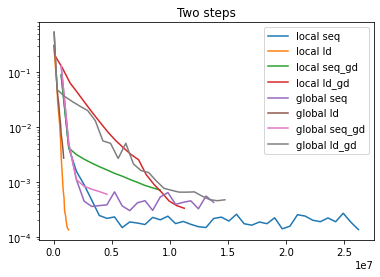

In [8]:
res = results[('local', 'sequential')]
plt.plot(res[1], res[2], label='local seq')
res = results[('local', 'largest-drop')]
plt.plot(res[1], res[2], label='local ld')
res = results[('local', 'sequential_gradient-descent')]
plt.plot(res[1], res[2], label='local seq_gd')
res = results[('local', 'largest-drop_gradient-descent')]
plt.plot(res[1], res[2], label='local ld_gd')
res = results[('global', 'sequential')]
plt.plot(res[1], res[2], label='global seq')
res = results[('global', 'largest-drop')]
plt.plot(res[1], res[2], label='global ld')
res = results[('global', 'sequential_gradient-descent')]
plt.plot(res[1], res[2], label='global seq_gd')
res = results[('global', 'largest-drop_gradient-descent')]
plt.plot(res[1], res[2], label='global ld_gd')
plt.yscale('log')
plt.legend()
plt.title('Two steps');

## Result validation

Largest-drop with local cost function converged the fastest for two Trotter steps. Are the resulting parameter values good enough? Check with RQD.

In [9]:
qubit_pairs = list(zip(range(0, num_sites - 1), range(1, num_sites)))

rtts = dict((qubits, CNOTBasedRtt(backend, qubits)) for qubits in qubit_pairs)
cxs = dict((qubits, cx_circuit(backend, *qubits)) for qubits in qubit_pairs)
cxs.update((qubits[::-1], cx_circuit(backend, *qubits[::-1])) for qubits in qubit_pairs)
two_step_circuit = two_steps(num_sites, aJ, am, omegadt, rtts=rtts, cxs=cxs)

forward_circuit = make_pnp_ansatz(num_qubits=num_sites, num_layers=num_sites // 2, initial_x_positions=[1, 2], structure=[(1, 2), (0, 1), (2, 3)], first_layer_structure=[(0, 1), (2, 3)])
forward_circuit.compose(two_step_circuit, inplace=True)

param_dict = dict(zip(forward_circuit.parameters, results[('local', 'largest-drop')][0]))
approx_statevector = backend.run(transpile(forward_circuit.assign_parameters(param_dict), backend=backend)).result().results[0].data.statevector

true_circuit = QuantumCircuit(num_sites)
true_circuit.x([0, 2])
true_circuit.compose(two_step_circuit, inplace=True)
true_circuit.compose(two_step_circuit, inplace=True)

true_statevector = backend.run(transpile(true_circuit, backend=backend)).result().results[0].data.statevector

print(np.square(np.abs(approx_statevector.conjugate() @ true_statevector)))

0.9997410314082583


In [10]:
print(results[('local', 'largest-drop')][0])

[5.89100276 0.78539816 1.56831984 0.78539816 1.22858455 2.32892981
 0.78920392 0.9405671  1.19581135 1.10219697]
